# 5.3. Experiments and Evaluation

### Utility Code

In [109]:
# Libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
import numpy as np

import warnings
warnings.filterwarnings('ignore')       # Disable long warnings when NaN values are encountered

In [110]:
# Constants
# color palette source: https://www.practicalpythonfordatascience.com/ap_seaborn_palette

geographical_palette = sns.color_palette("terrain", 8)
orbital_palette = sns.color_palette("Dark2", 8)
latitudinal_palette = sns.color_palette("tab10", 8)

geographical_cases = {
    "Landlocked": geographical_palette,
    "Coastal": geographical_palette,
}

orbital_cases = {
    "IntraOrbital": orbital_palette,
    "TransOrbital": orbital_palette,
}    

latitudinal_cases = {
    "Polar": latitudinal_palette,
    "Equatorial": latitudinal_palette,
}

directions = ["East", "West"] #, "North", "South"]

log_directory = "../../simulator/Logs/"

In [111]:
# Utility functions

def load_data(path: str):
    """Load CSV data."""
    if not os.path.isfile(path):
        raise Exception(f"The path {path} does not exist.")
    return pd.read_csv(path)


def load_json_data(relative_path: str):
    """Load JSON data."""
    path = os.path.join(log_directory, relative_path)
    if not os.path.isfile(path):
        raise Exception(f"The path {path} does not exist.")
    with open(path) as file:
        data = json.load(file)
    return pd.DataFrame(data['latencies'])


def graph(plot_fn, ax, cases, imax=1):
    """Plot the results of the plot function for each case and direction across frames.

    To enable RDiS, set imax to a value greater than 1.
    """
    defence = f"{imax}" if imax != 1 else "OFF"

    palette_idx = 0
    for case, palette in cases.items():
        print(palette_idx)
        for idx, direction in enumerate(directions):
            exists = plot_fn(case, direction, defence, palette, palette_idx, ax)
            # TODO: ONLY INCREASE IF THE LINE WAS USED!!!!
            if exists:
                palette_idx += 1

## 1. Network Performance relative to $i_\text{max}$
Plots the network performance relative to $i_\text{max}$ for $i_\text{max} \in \{3, 6, 9\}$.

0
2


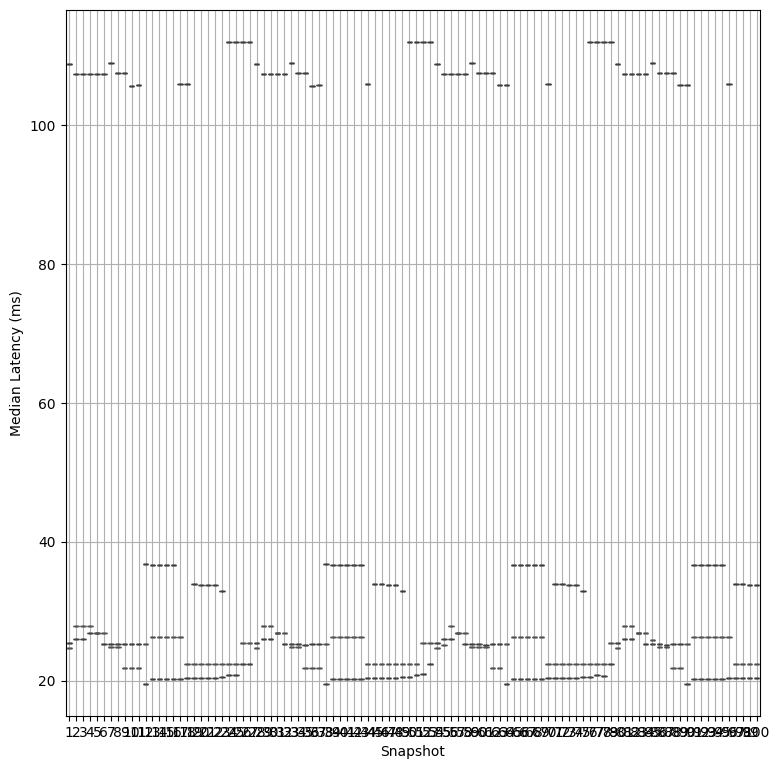

In [118]:
def plot_median_latency(case, direction, defence, palette, idx, ax):
    """Plot the median latency using deterministic routing."""
    filename = f"{case}_{direction}_{defence}_000"
    data = load_json_data(f"{filename}/rtt.json")
    data["median"] = data["rtt"].dropna().apply(np.median)

    line = sns.lineplot(
        data=data,
        x="frame",
        y="median",
        color=palette[idx],
        label=f"{case}_{direction}" if data["median"].notna().any() else "__nolegend__",
        ax=ax,
    )
    return True if data["median"].notna().any() else False


boxes = [f"median_{i}" for i in range(0, 100) ]

def plot_median_latency_random(case, direction, defence, palette, idx, ax, reps=100):
    """Plot the median latency using deterministic routing averaged over 100 runs."""
    # average the median of 100 runs.
    # TODO: There is a bug here. It's only picking the median of the first run, __not__ of everything.
    # TODO: COMPLETELY UNSURE IF THIS WORKS. NEED TO TEST TOMORROW.
    final_data = pd.DataFrame()

    for i in range(0, reps): # ran 100 instances.
        filename = f"{case}_{direction}_{defence}_{i:03d}"
        data = load_json_data(f"{filename}/rtt.json")
        data["median"] = data["rtt"].dropna().apply(np.median)
        data["median"] = data["median"].astype(float)
        data["iter"] = i
        data.drop(columns=["rtt"], inplace=True)
        final_data = pd.concat([final_data, data], axis=0) # TODO: don't do this iteratively. do concat at the end after collecting all copies.)
        # final_data[f"median_{i}"] = median 



        # if i == 0:
        #     data = load_json_data(f"{filename}/rtt.json")
        #     data["median"] = data["rtt"].dropna().apply(np.median)
        # else:
        #     temp_data =  load_json_data(f"{filename}/rtt.json")
        #     temp_data["median"] = temp_data["rtt"].dropna().apply(np.median)
        #     data["median"] = data["median"] + temp_data["median"]
        # print(f'MEDIAN OF FIRST {data["median"][1]}')
        # print(data)
    # data["median"] = data["median"] / reps
    # print(f'MEDIAN OF FIRST {data["median"][1]}')
    # print(data["median"])
    final_data = final_data[~final_data.index.duplicated()] # remove duplicates
    final_data = final_data.dropna()
    # display(final_data)
    # print(len(final_data["frame"]))
    # print(len(final_data["median"]))
    # line = sns.lineplot(
    #     data=data,
    #     x="frame",
    #     y="median",
    #     color=palette[idx],
    #     label=f"{case}_{direction}" if data["median"].notna().any() else "__nolegend__",
    #     ax=ax,
    # )
    sns.boxplot(data=final_data, x="frame", y="median")
    return True #if data["median"].notna().any() else False


# def plot_median_latency(case, direction, defence, palette, idx, ax):
#     if defence == "OFF":
#         filename = f"{case}_{direction}_{defence}_000"
#         data = load_json_data(f"{filename}/rtt.json")
#         data["median"] = data["rtt"].dropna().apply(np.median)
#     else:
#         # average the median of 100 runs.
#         # TODO: COMPLETELY UNSURE IF THIS WORKS. NEED TO TEST TOMORROW.
#         for i in range(1, 100): # ran 100 instances.
#             filename = f"{case}_{direction}_{defence}_{i:03d}"
#             if i == 1:
#                 data = load_json_data(f"{filename}/rtt.json")
#             else:
#                 temp_data =  load_json_data(f"{filename}/rtt.json")
#                 temp_data["median"] = temp_data["rtt"].dropna().apply(np.median)
#                 data["median"] = data["median"] + temp_data["median"]
#         data["median"] = data["median"] / 100
#     line = sns.lineplot(
#         data=data,
#         x="frame",
#         y="median",
#         color=palette[idx],
#         label=f"{case}_{direction}" if data["median"].notna().any() else "__nolegend__",
#         ax=ax,
#     )
#     return True if data["median"].notna().any() else False
    

def show_plot(fig, axs):
    for ax in np.ravel(axs):  # Flatten the array of Axes objects
        ax.set_xlabel("Snapshot")
        ax.set_ylabel("Median Latency (ms)")
        ax.tick_params(axis="y", labelcolor="black")
        ax.grid(True)

        # Remove the subplot if there are no lines.
        if len(ax.get_lines()) == 0:
            fig.delaxes(ax)

    plt.tight_layout()
    plt.show()


# TESTING. REMOVE LATER.
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
graph(plot_median_latency_random, axs[1, 0], geographical_cases, imax=3) # TODO: THE VISUALS SHOULD BE DIFFERENT
show_plot(fig, axs)

### Geographical

0
2
0
2
0
2


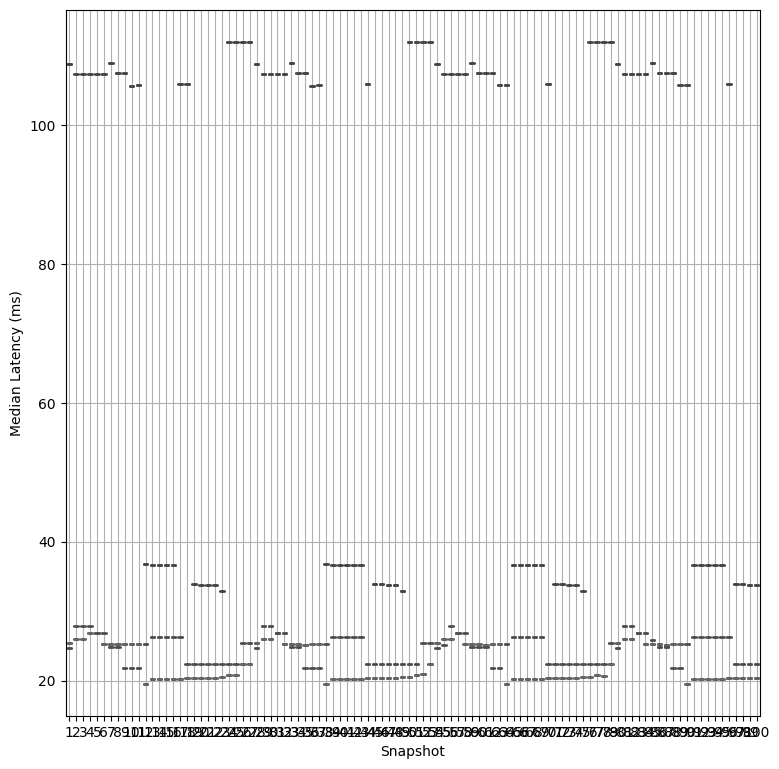

In [119]:
# Geographical
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Defence disabled
# graph(plot_median_latency, axs[0, 0], geographical_cases)

# imax = 3
# graph(plot_median_latency_random, axs[1, 0], geographical_cases, imax=3) # TODO: THE VISUALS SHOULD BE DIFFERENT

# # imax = 6
# graph(plot_median_latency_random, axs[0, 1], geographical_cases, imax=6) # TODO: THE VISUALS SHOULD BE DIFFERENT

# # # imax = 9
graph(plot_median_latency_random, axs[1, 1], geographical_cases, imax=9) # TODO: THE VISUALS SHOULD BE DIFFERENT

show_plot(fig, axs)

### Latitudinal

0
2


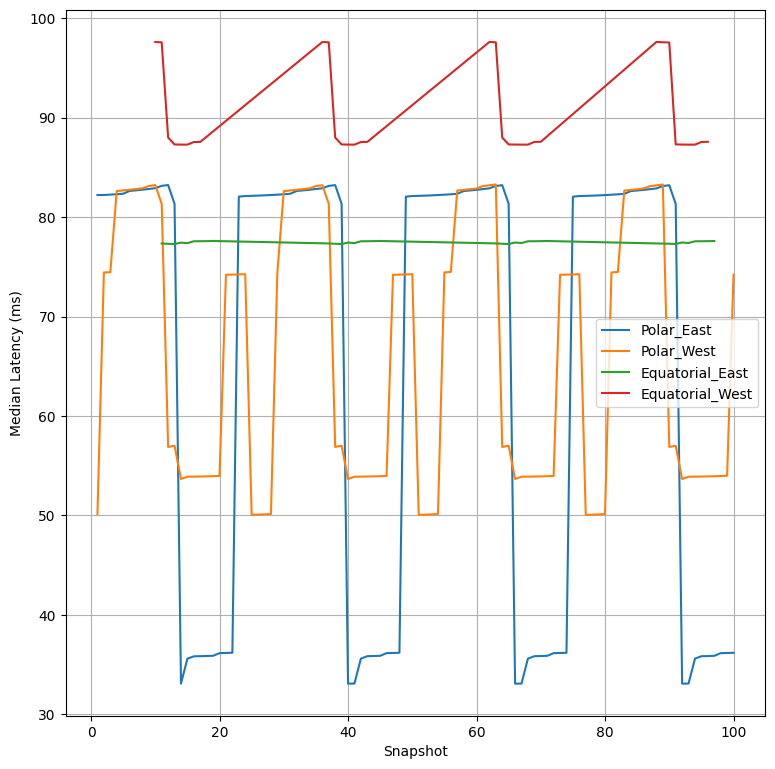

In [ ]:
# Latitudinal
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Defence disabled
graph(plot_median_latency, axs[0, 0], latitudinal_cases)

# imax = 3
# graph(plot_median_latency, axs[1, 0], latitudinal_cases, imax=3)

# # imax = 6
# graph(plot_median_latency, axs[2, 0], latitudinal_cases, imax=6)

# # imax = 9
# graph(plot_median_latency, axs[3, 0], latitudinal_cases, imax=9)

show_plot(fig, axs)

### Orbital

0
2


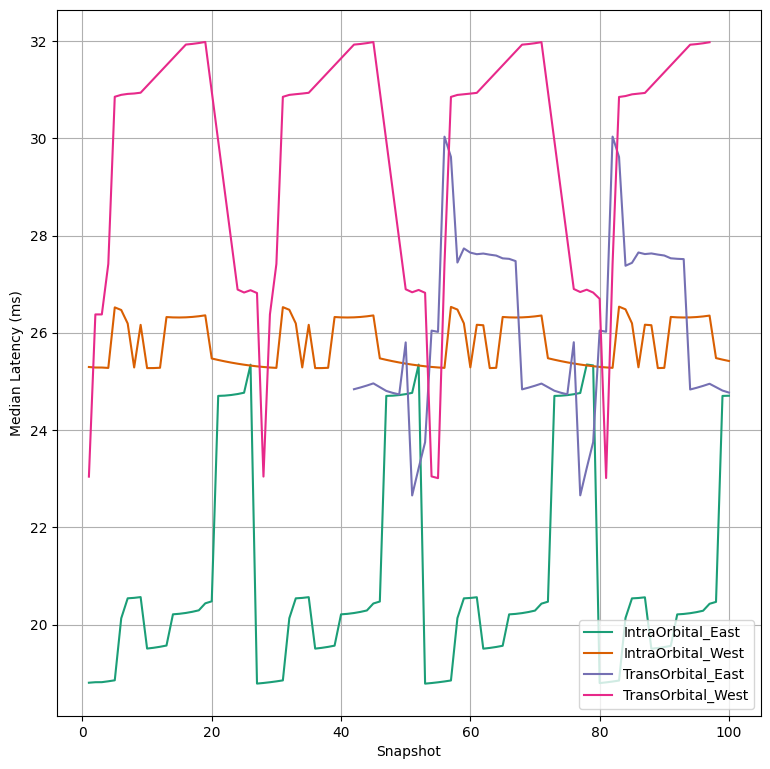

In [ ]:
# Orbital
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Defence disabled
graph(plot_median_latency, axs[0, 0], orbital_cases)

# # imax = 3
# graph(plot_median_latency, axs[1, 0], orbital_cases, imax=3)

# # imax = 6
# graph(plot_median_latency, axs[2, 0], orbital_cases, imax=6)

# # imax = 9
# graph(plot_median_latency, axs[3, 0], orbital_cases, imax=9)

show_plot(fig, axs)

## 2. Simulated Probability of Congestion relative to $i_\text{max}$
Plot the probability of congestion relative to $i_\text{max}$ using spare capacity data retrieved from the simulator for $i_\text{max} \in \{3, 6, 9\}$..

0


TypeError: plot_probability_congestion() takes 5 positional arguments but 6 were given

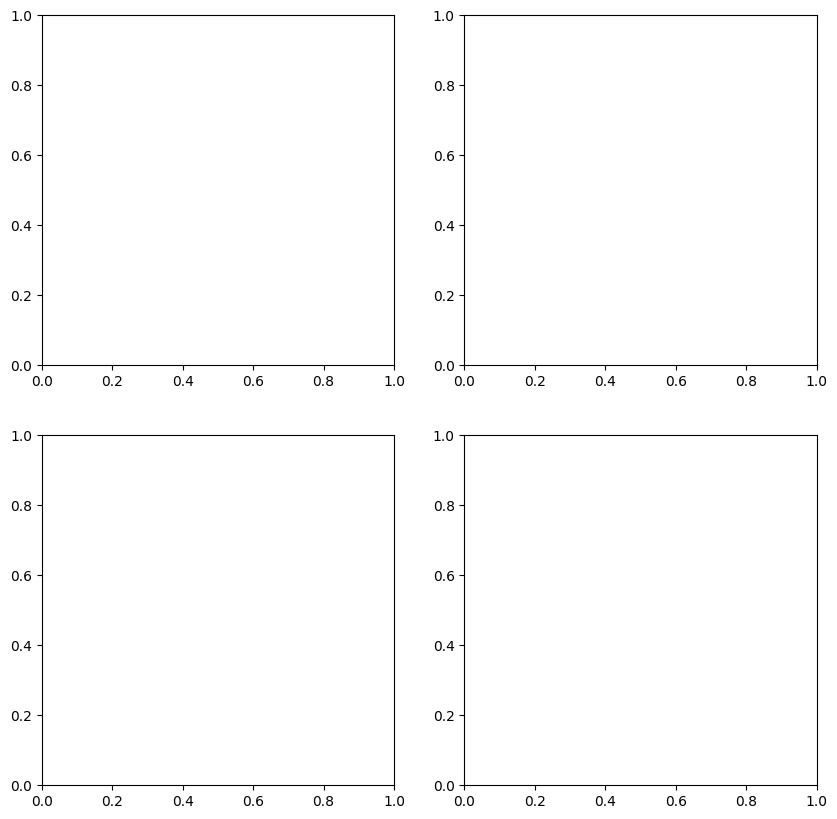

In [ ]:
def plot_probability_congestion(case, direction, defence, palette, idx):
    filename = f"{case}_{direction}_{defence}"
    data = load_data(f"{filename}/{filename}.csv")
    successes = data["FINAL CAPACITY"].value_counts()[0]
    probability = successes / len(data)
    sns.barplot(
        x="{case} {direction}",
        y=probability,
        color=palette[idx],
        ax=ax,
        label="{case} {direction}",
    )

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Defence disabled
graph(plot_probability_congestion, axs[0], geographical_cases)

# imax = 3
# graph(plot_probability_congestion, ax=axs[1], imax=3)

# # imax = 6
# graph(plot_probability_congestion, ax=axs[2], imax=6)

# # imax = 9
# graph(plot_probability_congestion, ax=axs[3], imax=9)


for ax in axs:
    # ax.set_xlabel("Snapshot")
    ax.set_ylabel("Probability of Congestion")
    # ax.set_ylim(-.5, 20.5)  # TODO: CHANGE THIS.
    # ax.tick_params(axis="y", labelcolor="black")
    ax.grid(True)

    # Remove the subplot if there is no data.
    if len(ax.get_lines()) == 0:
        fig.delaxes(ax)

plt.tight_layout()
plt.legend()
plt.show()

## 3. Simulated Expected Malicious Traffic relative to $i_\text{max}$

In [ ]:
def plot_expected_capacity(case, direction, defence, palette, idx):
    filename = f"{case}_{direction}_{defence}"
    data = load_data(f"{filename}/{filename}.csv")
    plot_data = pd.DataFrame(
        {
            "case direction": [f"{case} {direction}"],
            "mean": data.mean()["FINAL CAPACITY"],
            "stddev": data.std()["FINAL CAPACITY"],
        }
    )

    sns.barplot(
        x="case direction",
        y="mean",
        yerr="stddev",
        data=plot_data,
        color=palette[idx],
        ax=ax,
        label="{case} {direction}",
    )


fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Defence disabled
graph(plot_expected_capacity, axs[0], geographical_cases)

# # imax = 3
# graph(plot_expected_capacity, ax=axs[1], imax=3)

# # imax = 6
# graph(plot_expected_capacity, ax=axs[2], imax=6)

# # imax = 9
# graph(plot_expected_capacity, ax=axs[3], imax=9)


for ax in axs:
    # ax.set_xlabel("Snapshot")
    ax.set_ylabel("Expected Spare Capacity")
    # ax.set_ylim(-.5, 20.5)  # TODO: CHANGE THIS.
    # ax.tick_params(axis="y", labelcolor="black")
    ax.grid(True)

    # Remove the subplot if there is no data.
    if len(ax.get_lines()) == 0:
        fig.delaxes(ax)

plt.tight_layout()
plt.legend()
plt.show()